In [1]:
import re
import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.utils.data import Dataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from transformers import SamProcessor
from datasets import Dataset, Image, load_dataset, Features, Array3D, ClassLabel
from transformers import SamModel 
import loralib as lora
from concurrent.futures import ThreadPoolExecutor, as_completed

2024-05-02 22:27:48.273367: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 22:27:49.258635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset Preparation

## Helper functions

In [2]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    # dataset = dataset.cast_column("image", Image())
    # dataset = dataset.cast_column("label", Image())
    return dataset

def process_data(image_file, mask=False):
    # Open the image file
    image = PIL.Image.open(image_file)
    
    # Convert to RGB if not a mask
    if not mask:
        image = image.convert("RGB")
    else:
        # Convert to grayscale and binarize
        image = image.convert("L")
        image = image.point(lambda p: p > 0 and 1)
    
    # Resize the image
    image = image.resize((256, 256), PIL.Image.BILINEAR)
    
    return image

def load_data(file_paths, is_mask=False):
    # Load and process images/masks asynchronously
    with ThreadPoolExecutor(max_workers=8) as executor:
        # Submit all jobs to the executor
        future_to_file = {executor.submit(process_data, file, is_mask): file for file in file_paths}
        results = []
        for future in as_completed(future_to_file):
            res = future.result()
            if res is not None:
                results.append(res)
        return np.array(results)

## Load in subset of raw data as numpy arrays

In [3]:
subset_size = 100
train_filelist_xray = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Images/*.png'), key=numericalSort)
x_train = [process_data(file_xray) for file_xray in train_filelist_xray[:subset_size]]
masks = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Train Set/Ground-truths/*.png'), key=numericalSort)
y_train = [process_data(m, mask=True) for m in masks[:subset_size]]

## Make dataset dictionary

In [4]:
dataset = create_dataset(x_train, y_train)
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256>}

## Display sample

(-0.5, 255.5, 255.5, -0.5)

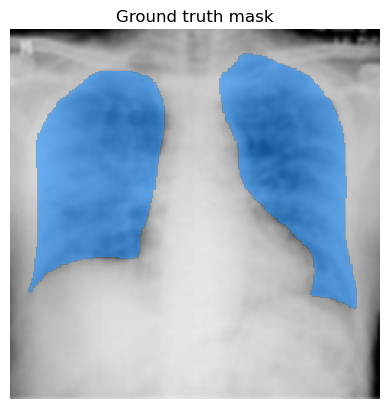

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
example = dataset[3]
image = example["image"]
fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes, False)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## SAM Dataset Prep

In [6]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  return bbox

In [7]:
class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    prompt = get_bounding_box(ground_truth_mask)
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask
    return inputs

# Fine-tuning

In [8]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/opt/conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
# Initialize Dataset
dataset = SAMDataset(dataset=dataset, processor=processor)
# Define the size of the entire dataset and the proportions for splitting
dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% for training
validation_size = dataset_size - train_size  # 20% for validation

# Split the dataset into training and validation sets
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# You can now use these in DataLoaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)

In [10]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [11]:
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda:0")
# TODO: fine-tune vision encoder and add lora to MLP layers; train layernorm
for name, param in model.named_parameters():
  if name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [12]:
# model

In [13]:
sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"SAM total params: {sam_total_params}")

SAM total params: 93729252


## LoRA integration

### Mask Decoder

In [47]:
for layer in model.mask_decoder.transformer.layers:
    # self_attn
    layer.self_attn.q_proj = lora.Linear(256, 256, r=8)
    layer.self_attn.k_proj = lora.Linear(256, 256, r=8)
    layer.self_attn.v_proj = lora.Linear(256, 256, r=8)
    # cross attn token to img
    layer.cross_attn_token_to_image.q_proj = lora.Linear(256, 128, r=8)
    layer.cross_attn_token_to_image.k_proj = lora.Linear(256, 128, r=8)
    layer.cross_attn_token_to_image.v_proj = lora.Linear(256, 128, r=8)
    # mlp
    layer.mlp.lin1 = lora.Linear(256, 2048, r=8)
    layer.mlp.lin2 = lora.Linear(2048, 256, r=8)
    # cross attn img to token
    layer.cross_attn_image_to_token.q_proj = lora.Linear(256, 128, r=8)
    layer.cross_attn_image_to_token.k_proj = lora.Linear(256, 128, r=8)
    layer.cross_attn_image_to_token.v_proj = lora.Linear(256, 128, r=8)

In [48]:
model.mask_decoder.transformer.final_attn_token_to_image.q_proj = lora.Linear(256, 128, r=8)
model.mask_decoder.transformer.final_attn_token_to_image.k_proj = lora.Linear(256, 128, r=8)
model.mask_decoder.transformer.final_attn_token_to_image.v_proj = lora.Linear(256, 128, r=8)

### Vision Encoder

In [49]:
for layer in model.vision_encoder.layers:
    layer.attn.qkv = lora.MergedLinear(768, 3*768, r=8, enable_lora=[True, True, True])
    layer.mlp.lin1 = lora.Linear(768, 3072, r=8)
    layer.mlp.lin2 = lora.Linear(3072, 768, r=8)

In [50]:
model.vision_encoder.neck.conv1 = lora.Conv2d(768, 256, kernel_size=1, r=8)
model.vision_encoder.neck.conv2 = lora.Conv2d(256, 256, kernel_size=1, r=8)

In [51]:
lora_sam_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"LoRA-SAM total params: {lora_sam_total_params}")
print(f"Percentage of params reduced: {((sam_total_params-lora_sam_total_params) / sam_total_params)}")

LoRA-SAM total params: 13440996
Percentage of params reduced: 0.8565976393367569


In [14]:
from torch.optim import Adam
import monai
# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [15]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 10
mean_epoch_losses = []
mean_epoch_val_losses = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    # Training phase
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()
      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())
    # print statistics
    print(f'EPOCH: {epoch}')
    mean_loss = mean(epoch_losses)
    print(f'Mean loss: {mean_loss}')
    mean_epoch_losses.append(mean_loss)
    # Validation phase
    model.eval()
    with torch.no_grad():
        epoch_val_losses = []
        for batch in tqdm(validation_dataloader):  # Make sure to use your validation DataLoader
            # forward pass
            outputs = model(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)
            # compute loss
            predicted_masks = outputs.pred_masks.squeeze(1)
            ground_truth_masks = batch["ground_truth_mask"].float().to(device)
            val_loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
            epoch_val_losses.append(val_loss.item())
        # print statistics
        mean_val_loss = torch.mean(torch.tensor(epoch_val_losses))
        print(f'EPOCH {epoch}: Validation Mean loss: {mean_val_loss.item()}')
        mean_epoch_val_losses.append(mean_val_loss.item())

 12%|█▎        | 5/40 [00:08<00:59,  1.71s/it]


KeyboardInterrupt: 

# Inference

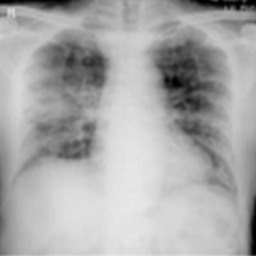

In [49]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 3

# load image
image = dataset[idx]["image"]
image

In [50]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [51]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [52]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

(1, 1, 4)
(256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

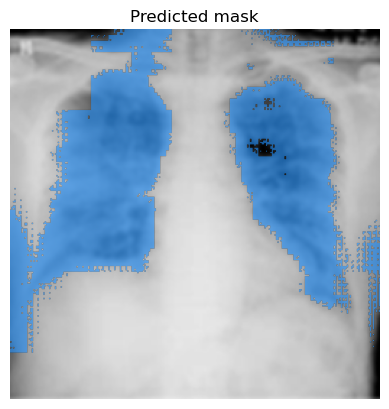

In [53]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    print(color.reshape(1, 1, -1).shape)
    print(mask.reshape(h, w, 1).shape)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

(-0.5, 255.5, 255.5, -0.5)

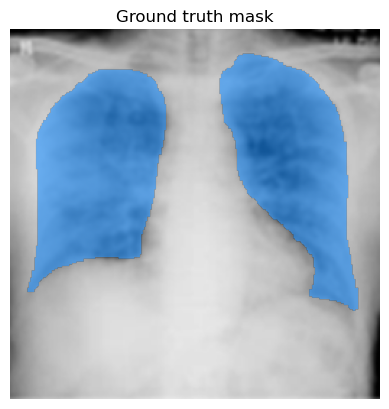

In [54]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

example = dataset[3]
image = example["image"]
fig, axes = plt.subplots()
axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes, False)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [55]:
import pandas as pd
import seaborn as sns

In [56]:
loss_df = {"Mean Loss": mean_epoch_losses}
loss_df = pd.DataFrame(loss_df).reset_index()
loss_df["Model"] = "Sam + LoRA"
loss_df = loss_df.rename(columns={'index': 'Epoch'})

In [57]:
# loss_df.to_csv("lora_sam_loss.csv")

In [58]:
# torch.save(model.state_dict(), "lora_sam.pth")

In [59]:
baseline_sam = pd.read_csv("sam_loss.csv", index_col=0)

In [60]:
combined_losses = pd.concat([loss_df, baseline_sam])

In [61]:
%%capture
loss_lineplot = sns.lineplot(combined_losses, x='Epoch', y='Mean Loss', hue='Model')
loss_lineplot_fig = loss_lineplot.figure.get_figure()
loss_lineplot_fig.savefig('loss_lineplot.png')

In [62]:
def calculateIoU(gtMask, predMask):
        # Calculate the true positives,
        # false positives, and false negatives
        tp = 0
        fp = 0
        fn = 0
        for i in range(len(gtMask)):
            for j in range(len(gtMask[0])):
                if gtMask[i][j] == 1 and predMask[i][j] == 1:
                    tp += 1
                elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                    fp += 1
                elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                    fn += 1
        # Calculate IoU
        iou = tp / (tp + fp + fn)
        return iou

In [63]:
print(f"Sample IoU: {calculateIoU(ground_truth_seg, medsam_seg)}")

Sample IoU: 0.6381479822453883


# Inference Exam

## Load Test Set

In [64]:
subset_size = 100

test_filelist_xray = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/*.png'))
x_test = np.array([process_data(file_xray) for file_xray in test_filelist_xray[:subset_size]])

test_masks = sorted(glob.glob('datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/*.png'))
y_test = np.array([process_data(m, mask=True) for m in test_masks[:subset_size]])
# binarize mask
y_test[y_test > 0] = 1 

print(f"Test data shape: {x_test.shape}")
print(f"Test labels (masks) data shape: {y_test.shape}")

Test data shape: (100, 256, 256, 3)
Test labels (masks) data shape: (100, 256, 256)


In [65]:
test_filelist_xray[:11]

['datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16280_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16628_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E16837_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17130_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17511_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17539_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17682_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E17934_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E18100_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Images/sub-S08047_ses-E26555_ru

In [66]:
test_masks[:11]

['datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16280_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16628_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E16837_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17130_run-1_bp-chest_cr.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17511_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17539_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17682_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E17934_run-1_bp-chest_vp-ap_dx.png',
 'datasets/QaTa-COV19/QaTa-COV19-v2/Test Set/Ground-truths/mask_sub-S08047_ses-E1810

In [71]:
def create_dataset(images, labels):
    dataset = Dataset.from_dict({"image": images,
                                "label": labels})
    dataset = dataset.cast_column("image", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset
test_dataset = create_dataset(x_test, y_test)
test_dataset

/opt/conda/lib/python3.11/site-packages/datasets/features/image.py:339: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/opt/conda/lib/python3.11/site-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


Dataset({
    features: ['image', 'label'],
    num_rows: 100
})

In [72]:
test_ious = []
for idx, sample in enumerate(test_dataset):
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(sample["label"])
    prompt = get_bounding_box(ground_truth_mask)

    image = sample["image"]
    # prepare image + box prompt for the model
    inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
    
    # forward pass
    with torch.no_grad():
      outputs = model(**inputs, multimask_output=False)
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    iou = calculateIoU(ground_truth_mask, medsam_seg)
    test_ious.append(iou)

In [73]:
print(f"Average IoUs over 100 test samples: {mean(test_ious)}")

Average IoUs over 100 test samples: 0.31679712669981375
